In [1]:
%run ./Preamble.ipynb

# Retrieve all models for which activations have been retrieved
all_models = PM.check_for_existing_patterns("activations")
print(all_models)


['gpt2-xl', 'gpt2-xl-untrained_1', 'gpt2', 'gpt2-untrained_1', 'gpt2-untrained_2', 'gpt2-untrained_3', 'gpt2-untrained_4', 'gpt2-untrained_5', 'gpt2-untrained_6', 'gpt2-untrained_7', 'gpt2-untrained_8', 'gpt2-untrained_9', 'gpt2-untrained_1_weight_config_all', 'gpt2-untrained_2_weight_config_all', 'gpt2-untrained_3_weight_config_all', 'gpt2-untrained_4_weight_config_all', 'gpt2-untrained_5_weight_config_all', 'gpt2-untrained_6_weight_config_all', 'gpt2-untrained_7_weight_config_all', 'gpt2-untrained_8_weight_config_all', 'gpt2-untrained_9_weight_config_all']


\begin{figure}
    \centering
    \includesvg[width=\linewidth]{inputs/fig/brainscores_pereira2018}
    \caption{caption for fig:brainscores pereira2018}
    \label{fig:brainscores_pereira2018}
    \end{figure} % \ref{fig:brainscores_pereira2018}


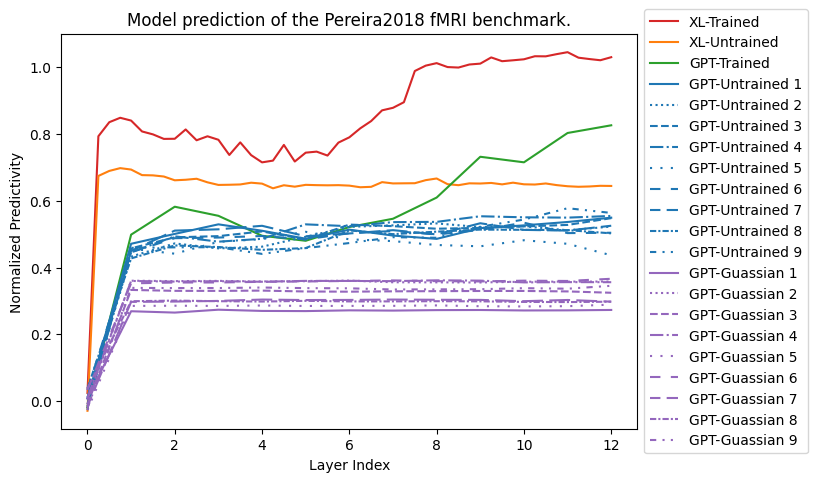

\begin{figure}
    \centering
    \includesvg[width=\linewidth]{inputs/fig/brainscores_blank2014}
    \caption{caption for fig:brainscores blank2014}
    \label{fig:brainscores_blank2014}
    \end{figure} % \ref{fig:brainscores_blank2014}


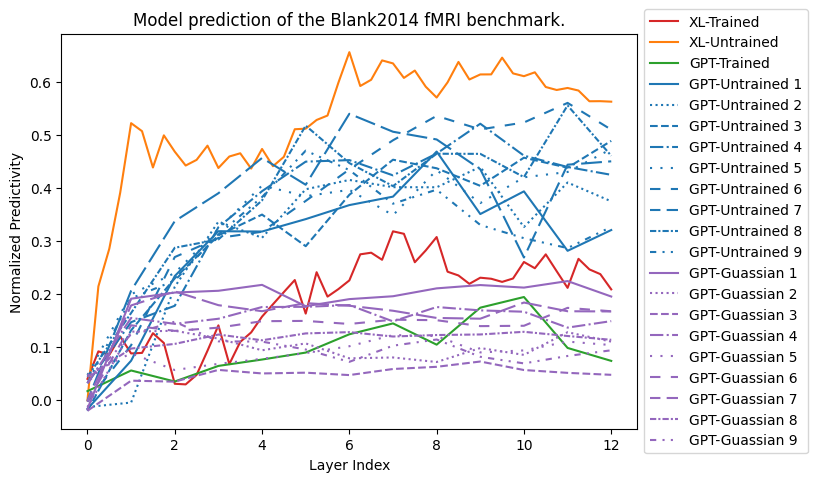

In [2]:
_=importlib.reload(my_latex_tools)
from my_latex_tools import *
_=importlib.reload(DataDisplayer)
DD = DataDisplayer.DataDisplayer(PM)
# https://stackoverflow.com/questions/29568110/how-to-use-ax-with-pandas-and-matplotlib

# ============================================================
# Format Scores File for Analysis
# ============================================================

def format_scores_file(csv_file):
    """
    Formats a raw score CSV file into a structured DataFrame.

    Args:
        csv_file (str): Path to the score CSV file.

    Returns:
        pd.DataFrame: Formatted DataFrame containing model, layer, score, and error information.
    """
    df = pd.read_csv(csv_file)

    # Extract the filename and parse model and benchmark information
    file_path = list(df)[2]
    filename = re.findall(r'.*/([^/]*)', file_path)[0]
    regex = re.compile(r'(.*)_([^_]*-encoding)_.*_score_raw')
    model, benchmark = regex.findall(filename)[0]
    
    # Check if model includes a weight configuration
    if "weight_config" in model:
        regex = re.compile(r'(gpt2.*)_(weight_config_.*)')
        base_model, config = regex.findall(model)[0]
    else:
        base_model, config = (model, "")

    # Extract layer scores and errors
    layers, scores, errors = [], [], []
    for layer in df['layer'].unique():
        score = df[(df['layer'] == layer) & (df['aggregation'] == 'center')].iloc[0, 2]
        error = df[(df['layer'] == layer) & (df['aggregation'] == 'error')].iloc[0, 2]
        scores.append(score)
        errors.append(error)
        layers.append(layer)
    
    # Create DataFrame from parsed information
    df_dict = {
        'benchmark': [benchmark] * len(layers),
        'model': [model] * len(layers),
        'layer': layers,
        'score': scores,
        'error': errors,
        'base_model': [base_model] * len(layers),
        'config': [config] * len(layers),
        'layer_idx': list(range(len(layers))),
    }
    
    return pd.DataFrame(df_dict)


# ============================================================
# Combine Multiple Score Files for Analysis
# ============================================================


def combine_scores():
    """
    Combines multiple score files into a single DataFrame, sorted by benchmark, model, and layer.

    Returns:
        pd.DataFrame: Combined and sorted DataFrame of all score data.
    """
    from pathlib import Path

    # Get list of score file paths
    score_dir = PM.directories["scores"]
    score_paths = list(str(p) for p in Path(score_dir).glob('*_score_raw.csv'))
    
    # Format and combine all score files
    df = pd.concat([format_scores_file(x) for x in score_paths]).sort_values(
        by=["benchmark", "config", "model", "layer_idx"],
        ascending=[False, True, True, True],
        na_position="first",
        kind="mergesort"
    ).reset_index(drop=True)

    # Sort by model index using the DataDisplayer utility
    df = df.sort_values("model", key=lambda x: pd.Series.map(x, DD.model_to_modelIdxs), kind="mergesort")

    # Save combined scores
    PM.save_data("scores", "scores.csv", df)
    
    return df

# Combine scores and prepare DataFrame for analysis
df = combine_scores()
df = DD.prep_df_for_analysis(df)
df = df[df["model"].isin(all_models)]

# Scale layer_idx in the 48 layer GPT-2 XL models to align with the 12 layer non-XL models
if len(df[df['layer_idx'] == 48]):
    mask = df["model"].isin(DD.gpt2xl_models)
    df["layer_idx"] = df["layer_idx"].mask(mask, df["layer_idx"] * 12 / 48)
    

# ============================================================
# Plot Brain Scores by Model Group
# ============================================================

def plot_brainscores_by_group(scores_df, benchmark="Pereira2018-encoding"):
    """
    Plots brain score predictions for various models by layer index.

    Args:
        scores_df (pd.DataFrame): DataFrame containing the scores.
        benchmark (str, optional): Benchmark name to filter scores. Defaults to "Pereira2018-encoding".
    """
    display_benchmark = DD.df_display_replacer["benchmark"][benchmark]
    scores_df = scores_df[scores_df["benchmark"] == benchmark]
    
    # Set figure size and labels
    fig_size = (6.5, 4.5)
    fig, ax = plt.subplots()
    plt.tight_layout()
    fig.set_size_inches(fig_size)
    ax.set_title(f"Model prediction of the {display_benchmark} fMRI benchmark.")
    ax.set_xlabel("Layer Index")
    ax.set_ylabel("Normalized Predictivity")

    # Plot the score for each model
    for model, df in scores_df.groupby("model", sort=False):
        color = DD.model_to_linecolor[model]
        ls = DD.model_to_linestyle[model]
        label = DD.model_to_label[model]
        ax.plot(df["layer_idx"], df["score"], label=label, color=color, ls=ls)
    
    # Adjust legend and save the figure
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Place legend to the right
    save_figure_for_thesis(fig, fn=f"brainscores_{display_benchmark}", v=1)
    plt.show()


# Plot brain scores for different benchmarks
plot_brainscores_by_group(df, benchmark="Pereira2018-encoding")
plot_brainscores_by_group(df, benchmark="Blank2014fROI-encoding")